In [5]:
!ls

ecg  ecg.tar.gz  TestSimple.py	Untitled.ipynb


In [33]:
from sklearn.model_selection import train_test_split
import numpy as np
import os


def load_and_preprocess(file_path):
    """Load ECG data and preprocess."""
    with open(file_path, 'r') as file:
        lines = file.readlines()
    measurements = []
    for line in lines:
        try:
            # Split the line by spaces and take the last element as the measurement
             # Split the line by spaces and take the last element as the measurement
            measurement = float(line.strip().split()[-1])
            measurements.append(measurement)
        finally:
            # Ensure all sequences are of length 75. Pad or truncate as necessary.
            if len(measurements) > 75:
                measurements = measurements[:75]
            elif len(measurements) < 75:
                measurements.extend([0.0] * (75 - len(measurements)))
            
    return measurements



def load_and_preprocess_combined(file_path_0, file_path_1):
    """Load ECG data from both leads and combine."""
    measurements_0 = load_and_preprocess(file_path_0)
    measurements_1 = load_and_preprocess(file_path_1)
    return measurements_0 + measurements_1



abnormal_path = 'ecg/abnormal/'
normal_path = 'ecg/normal/'
abnormal_files = [f for f in os.listdir(abnormal_path) if (f.endswith('.0') or f.endswith('.1'))]
normal_files = [f for f in os.listdir(normal_path) if (f.endswith('.0') or f.endswith('.1'))]



# Combine data from both leads
combined_abnormal_data = [load_and_preprocess_combined(os.path.join(abnormal_path, file.replace('.1', '.0')),
                                                      os.path.join(abnormal_path, file)) for file in abnormal_files if file.endswith('.1')]
combined_normal_data = [load_and_preprocess_combined(os.path.join(normal_path, file.replace('.1', '.0')),
                                                    os.path.join(normal_path, file)) for file in normal_files if file.endswith('.1')]

# Assign labels
abnormal_labels = [1] * len(combined_abnormal_data)
normal_labels = [0] * len(combined_normal_data)

# Combine data and labels
X_data = combined_abnormal_data + combined_normal_data
y_data = abnormal_labels + normal_labels

print(len(X_data), len(y_data))


# Convert to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.20, random_state=42)

print(X_train.shape, X_val.shape)

200 200
(160, 150) (40, 150)


In [34]:
import matplotlib as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam


# Define the Keras model
model = keras.Sequential([
    layers.Input(shape=(150,)),  # Input layer
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])
# Compile the model

#optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
optimizer = Adam(learning_rate=0.001) #To reproduce result in rapport use 0.0001
#optimizer = 
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=34, verbose =1)
# Evaluate the model's performance
val_loss, val_accuracy = model.evaluate(X_val, y_val)


print(model.summary())
#intermediate_model = keras.Model(inputs=model.input, outputs=model.layers[1].output)
#intermediate_output = intermediate_model.predict(X_val)
#print(intermediate_output)

Epoch 1/100
5/5 [==============================] - 2s 49ms/step - loss: 1.3742 - accuracy: 0.5938 - val_loss: 1.0107 - val_accuracy: 0.3000
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 1.0080 - accuracy: 0.4000 - val_loss: 0.6859 - val_accuracy: 0.6250
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 0.7481 - accuracy: 0.6062 - val_loss: 0.7629 - val_accuracy: 0.6250
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 0.6860 - accuracy: 0.6250 - val_loss: 0.8105 - val_accuracy: 0.4500
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 0.6554 - accuracy: 0.5375 - val_loss: 0.7147 - val_accuracy: 0.4500
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 0.6483 - accuracy: 0.5938 - val_loss: 0.5809 - val_accuracy: 0.5750
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 0.6165 - accuracy: 0.6250 - val_loss: 0.6915 - val_accuracy: 0.5500
Epoch 8/100
5/5 [===

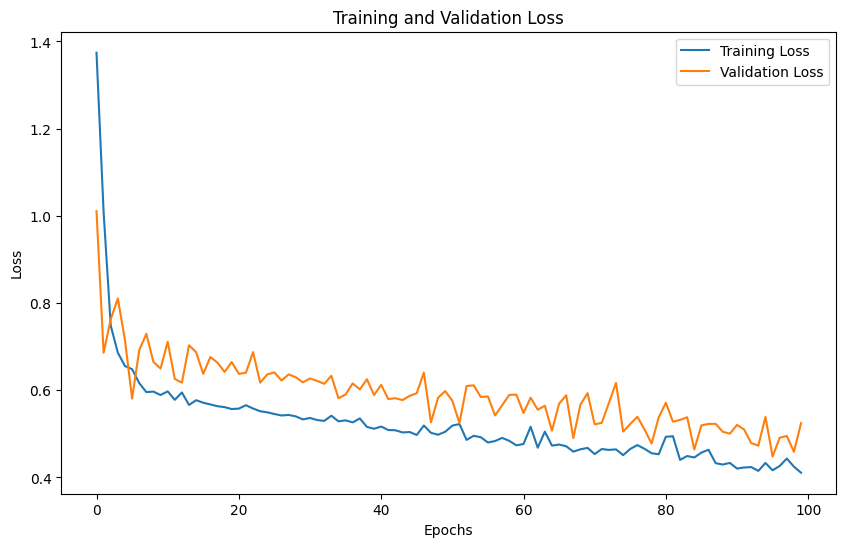

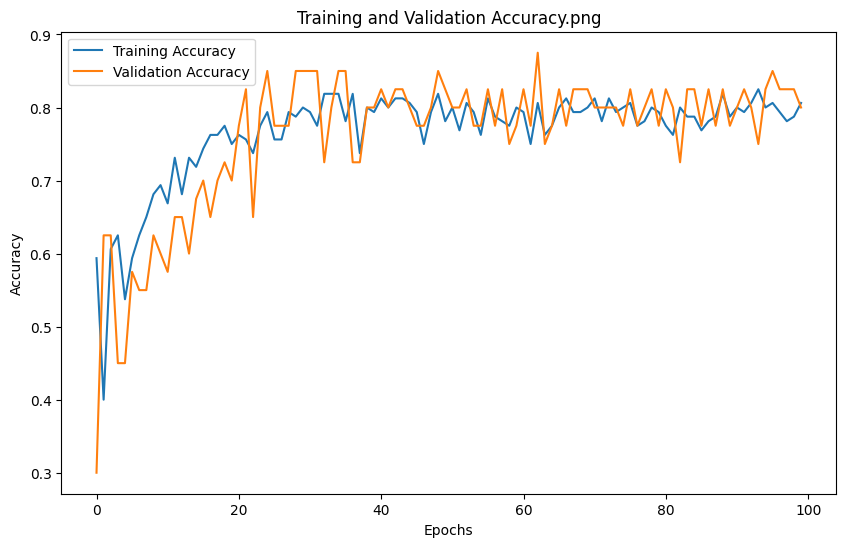

In [35]:
import matplotlib.pyplot as plt

# Plotting the training loss and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('TrainingandValidationLoss.png')
plt.show()

# Plotting the training accuracy and validation accuracy
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy.png')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('TrainingandValidationAccuracy.png')
plt.show()


In [29]:
# Make predictions on the validation set
predicted_probabilities = model.predict(X_val)

# Convert probabilities to class labels
predicted_labels = (predicted_probabilities > 0.5).astype("int32")

# Compute the accuracy
correct_predictions = np.equal(predicted_labels.flatten(), y_val.flatten()).sum()
accuracy = correct_predictions / len(y_val)
# Print the first few predictions and the actual labels
print("Predicted Labels:", predicted_labels[:20].flatten())
print("Actual Labels   :", y_val[:20].flatten())
print(f"Accuracy: {accuracy * 100:.2f}%")

print(f"Accuracy :{val_accuracy* 100:.2f}% Loss : {val_loss}")


2/2 [==============================] - 0s 3ms/step
Predicted Labels: [0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1]
Actual Labels   : [0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0]
Accuracy: 80.00%
Accuracy :80.00% Loss : 0.6079009771347046
